loading data from /content/creditcard.csv...

data shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.79

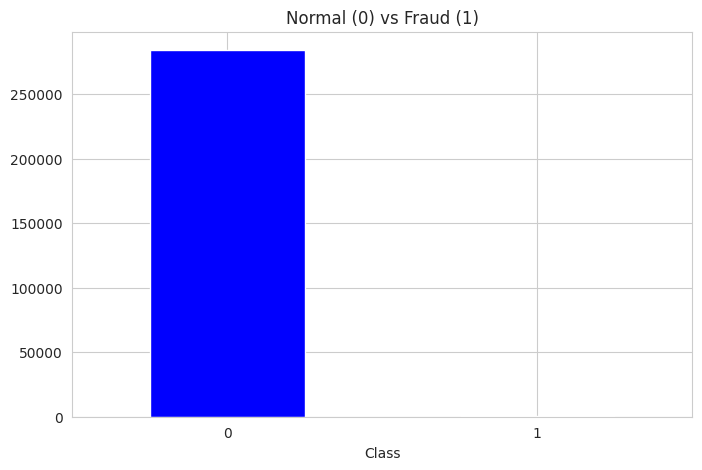

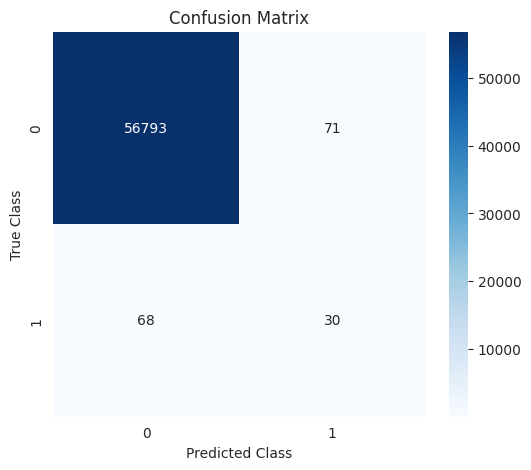

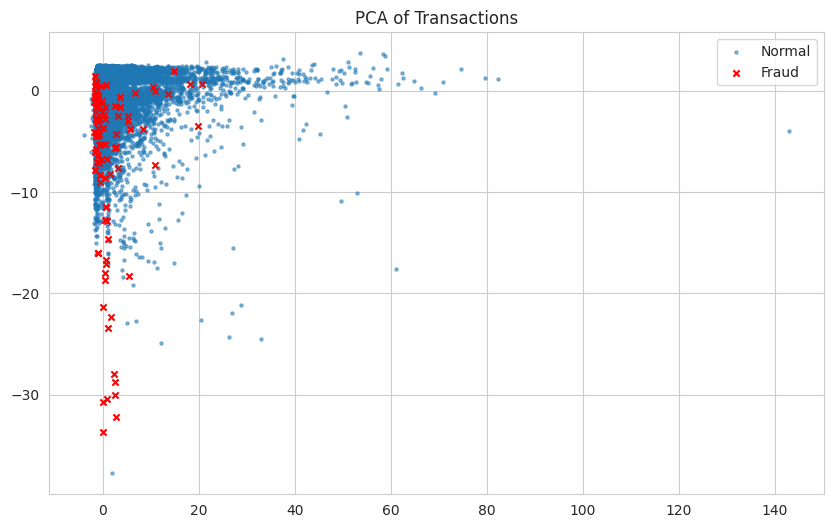

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
import os


warnings.filterwarnings('ignore')
file_path = '/content/creditcard.csv'

# checking existence to prevent crash, otherwise making dummy data
if os.path.exists(file_path):
    print(f"loading data from {file_path}...")
    df = pd.read_csv(file_path)
else:
    print("file not found, generating dummy data for demo...")
    data = {f'V{i}': np.random.normal(0, 1, 5000) for i in range(1, 29)}
    data['Time'] = np.random.randint(0, 172792, 5000)
    data['Amount'] = np.random.exponential(50, 5000)
    data['Class'] = [1 if i < 50 else 0 for i in range(5000)] # 1% fraud
    df = pd.DataFrame(data)


print(f"\ndata shape: {df.shape}")
print(df.head())

# dropping nulls immediately if any exist
if df.isnull().values.any():
    df.dropna(inplace=True)

# checking class imbalance - crucial for fraud detection
print("\n--- Class Distribution ---")
print(df['Class'].value_counts())

# simple bar chart to visualize the imbalance
plt.figure(figsize=(8, 5))
df['Class'].value_counts().plot(kind='bar', color=['b', 'r'], rot=0)
plt.title("Normal (0) vs Fraud (1)")
plt.savefig('class_dist.png')

# using RobustScaler as it handles outliers better than standard scaler
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# removing the original unscaled columns
df.drop(['Time','Amount'], axis=1, inplace=True)

# define features (X) and target (Y)
X = df.drop('Class', axis=1)
Y = df['Class']

# splitting data - even in unsupervised, we need a test set to validate
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"\ntrain size: {X_train.shape}, test size: {X_test.shape}")


contamination = len(df[df['Class'] == 1]) / len(df)
if contamination == 0: contamination = 0.01
print(f"contamination rate: {contamination:.4f}")

# using Isolation Forest, the go-to for anomaly detection
iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

print("\ntraining the isolation forest model...")
iso_forest.fit(X_train)


# 5. PREDICTION & OUTPUT
print("detecting anomalies in test set...")
y_pred = iso_forest.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1


n_errors = (y_pred != Y_test).sum()
print(f"total errors: {n_errors}")
print(f"Accuracy Score: {accuracy_score(Y_test, y_pred):.4f}")

print("\n--- Classification Report ---")
print(classification_report(Y_test, y_pred))


# 6. VISUALIZATION OF RESULTS
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.savefig('confusion_matrix.png')

# using PCA to visualize high-dim data in 2D
print("\ngenerating PCA plot for visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(10, 6))
# plot normal transactions in blue
plt.scatter(X_pca[Y_test == 0, 0], X_pca[Y_test == 0, 1], label='Normal', alpha=0.5, s=5)
# plot fraud transactions in red
plt.scatter(X_pca[Y_test == 1, 0], X_pca[Y_test == 1, 1], label='Fraud', c='r', s=20, marker='x')
plt.title('PCA of Transactions')
plt.legend()
plt.savefig('pca_plot.png')

print("analysis complete, check the output images.")